# ESM Model

Este notebook emplea embeddings generados por el modelo ESM-2 (t6_8M_UR50D), un modelo de lenguaje entrenado sobre millones de secuencias proteicas, para representar proteínas como vectores densos de información biológica. Estas representaciones se utilizan como entrada para una red neuronal siamesa tipo MLP diseñada para comparar pares de proteínas y predecir su interacción. Se incluyen técnicas de regularización y entrenamiento en precisión mixta para mejorar el rendimiento y la eficiencia del modelo.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF="expandable_segments:True"

In [3]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [4]:
import pandas as pd

df = pd.read_parquet("../datasets/df_string_balanced.parquet")

In [5]:
df.head()

,protein1,protein2,label,sequence1,sequence2
0,9606.ENSP00000000233,9606.ENSP00000257770,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MCPRAARAPATLLLALGAVLWPAAGAWELTILHTNDVHSRLEQTSE...
1,9606.ENSP00000000233,9606.ENSP00000226004,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSGSFELSVQDLNDLLSDGSGCYSLPSQPCNEVTPRIYVGNASVAQ...
2,9606.ENSP00000000233,9606.ENSP00000262455,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MHPAVFLSLPDLRCSLLLLVTWVFTPVTTEITSLDTENIDEILNNA...
3,9606.ENSP00000000233,9606.ENSP00000263265,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MEGSRPRSSLSLASSASTISSLSSLSPKKPTRAVNKIHAFGKRGNA...
4,9606.ENSP00000000233,9606.ENSP00000365686,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MGMSKSHSFFGYPLSIFFIVVNEFCERFSYYGMRAILILYFTNFIS...


In [6]:
from models.esm.embedder import ESMEmbedder

output_dir = "../processed_data/esm_embeddings"

if not os.path.exists(output_dir):
    seqs1 = df["sequence1"].tolist()
    seqs2 = df["sequence2"].tolist()
    labels = df["label"].to_numpy()

    embedder = ESMEmbedder(batch_size=32)
    X1, X2 = embedder.embed_all(seqs1, seqs2)

    embedder.save(X1, X2, labels, output_dir=output_dir)

    # clear variables
    del embedder, seqs1, seqs2, X1, X2, labels
    gc.collect()
    torch.cuda.empty_cache()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Encoding with ESM-2: 100%|██████████| 57139/57139 [8:49:12<00:00,  1.80it/s]   


---Saved: ../processed_data/esm_embeddings/esm_protein1.pt
---Saved: ../processed_data/esm_embeddings/esm_protein2.pt
---Saved: ../processed_data/esm_embeddings/esm_labels.pt


In [4]:
from models.esm.train_pipeline import train_model
from models.esm.dataset import ESMDataset
from torch.utils.data import DataLoader, random_split

data_dir = "../processed_data/esm_embeddings"
batch_size = 64

dataset = ESMDataset(data_dir)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

model = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path="../models",
    input_dim=320,
    hidden_dim=512,
    lr=1e-3,
    epochs=50,
    patience=6
)


Epoch 1/50


Train loss: 0.5236


Val loss: 0.4781 | Accuracy: 0.7687
-- Best model saved.

Epoch 2/50


Train loss: 0.4738


Val loss: 0.4465 | Accuracy: 0.7901
-- Best model saved.

Epoch 3/50


Train loss: 0.4467


Val loss: 0.4276 | Accuracy: 0.8026
-- Best model saved.

Epoch 4/50


Train loss: 0.4270


Val loss: 0.4143 | Accuracy: 0.8096
-- Best model saved.

Epoch 5/50


Train loss: 0.4112


Val loss: 0.4055 | Accuracy: 0.8145
-- Best model saved.

Epoch 6/50


Train loss: 0.3988


Val loss: 0.3984 | Accuracy: 0.8200
-- Best model saved.

Epoch 7/50


Train loss: 0.3875


Val loss: 0.3902 | Accuracy: 0.8238
-- Best model saved.

Epoch 8/50


Train loss: 0.3781


Val loss: 0.3856 | Accuracy: 0.8265
-- Best model saved.

Epoch 9/50


Train loss: 0.3698


Val loss: 0.3836 | Accuracy: 0.8279
-- Best model saved.

Epoch 10/50


Train loss: 0.3619


Val loss: 0.3809 | Accuracy: 0.8297
-- Best model saved.

Epoch 11/50


Train loss: 0.3547


Val loss: 0.3775 | Accuracy: 0.8322
-- Best model saved.

Epoch 12/50


Train loss: 0.3491


Val loss: 0.3728 | Accuracy: 0.8342
-- Best model saved.

Epoch 13/50


Train loss: 0.3421


Val loss: 0.3732 | Accuracy: 0.8338

Epoch 14/50


Train loss: 0.3377


Val loss: 0.3726 | Accuracy: 0.8350
-- Best model saved.

Epoch 15/50


Train loss: 0.3321


Val loss: 0.3692 | Accuracy: 0.8364
-- Best model saved.

Epoch 16/50


Train loss: 0.3273


Val loss: 0.3688 | Accuracy: 0.8372
-- Best model saved.

Epoch 17/50


Train loss: 0.3233


Val loss: 0.3687 | Accuracy: 0.8374
-- Best model saved.

Epoch 18/50


Train loss: 0.3184


Val loss: 0.3708 | Accuracy: 0.8381

Epoch 19/50


Train loss: 0.3147


Val loss: 0.3676 | Accuracy: 0.8395
-- Best model saved.

Epoch 20/50


Train loss: 0.3112


Val loss: 0.3681 | Accuracy: 0.8387

Epoch 21/50


Train loss: 0.3072


Val loss: 0.3676 | Accuracy: 0.8396
-- Best model saved.

Epoch 22/50


Train loss: 0.3040


Val loss: 0.3679 | Accuracy: 0.8396

Epoch 23/50


Train loss: 0.3013


Val loss: 0.3670 | Accuracy: 0.8398
-- Best model saved.

Epoch 24/50


Train loss: 0.2982


Val loss: 0.3680 | Accuracy: 0.8407

Epoch 25/50


Train loss: 0.2949


Val loss: 0.3674 | Accuracy: 0.8398

Epoch 26/50


Train loss: 0.2928


Val loss: 0.3650 | Accuracy: 0.8410
-- Best model saved.

Epoch 27/50


Train loss: 0.2895


Val loss: 0.3658 | Accuracy: 0.8405

Epoch 28/50


Train loss: 0.2872


Val loss: 0.3670 | Accuracy: 0.8414

Epoch 29/50


Train loss: 0.2844


Val loss: 0.3672 | Accuracy: 0.8417

Epoch 30/50


Train loss: 0.2826


Val loss: 0.3649 | Accuracy: 0.8416
-- Best model saved.

Epoch 31/50


Train loss: 0.2800


Val loss: 0.3699 | Accuracy: 0.8416

Epoch 32/50


Train loss: 0.2780


Val loss: 0.3711 | Accuracy: 0.8410

Epoch 33/50


Train loss: 0.2756


Val loss: 0.3652 | Accuracy: 0.8427

Epoch 34/50


Train loss: 0.2733


Val loss: 0.3697 | Accuracy: 0.8417

Epoch 35/50


Train loss: 0.2716


Val loss: 0.3700 | Accuracy: 0.8418

Epoch 36/50


Train loss: 0.2692


Val loss: 0.3698 | Accuracy: 0.8429
!! Early stopping at epoch 36


Test Accuracy : 0.8436
Test F1 Score : 0.8426
Test ROC AUC  : 0.9220



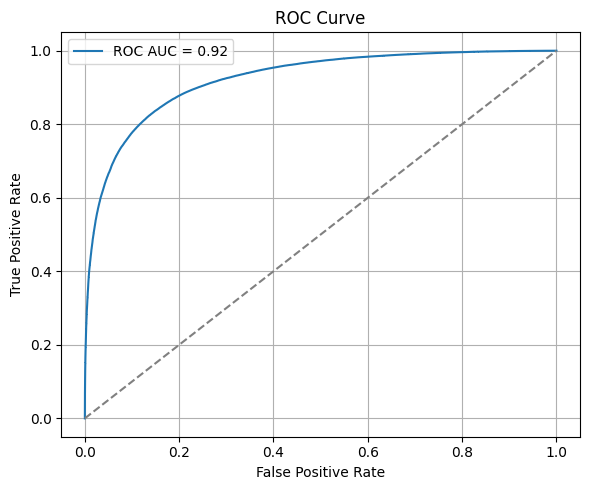

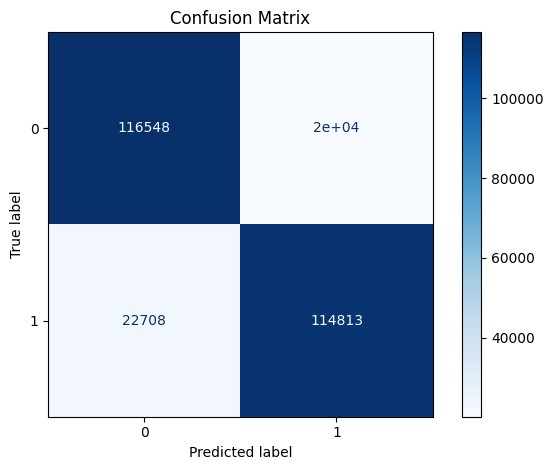

In [5]:
from pipelines import evaluate_model
evaluate_model(model, test_loader, device=torch.device("cuda"))